[*********************100%%**********************]  1 of 1 completed

2023-12-17 00:28:56.202 | INFO     | FinMind.data.finmind_api:get_data:123 - download TaiwanStockHoldingSharesPer, data_id: 0050



總績效 0.1084 
交易次數 16 
平均績效 0.0068 
平均持有天數 43 天
勝率 0.56 
平均獲利 0.0397 
平均虧損 -0.0356 
賺賠比 1.116 
期望值 0.1902 
獲利平均持有天數 44 天
虧損平均持有天數 42 天
最大連續虧損 -0.0723
最大資金回落 0.1566


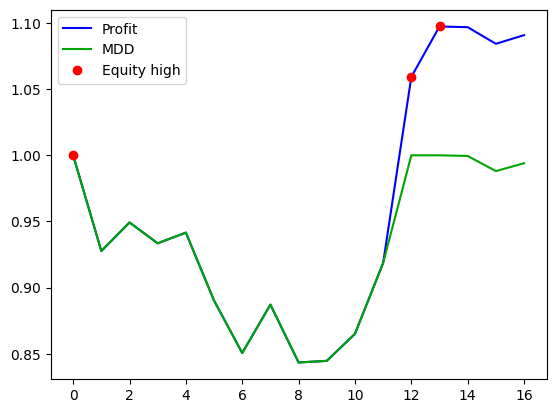

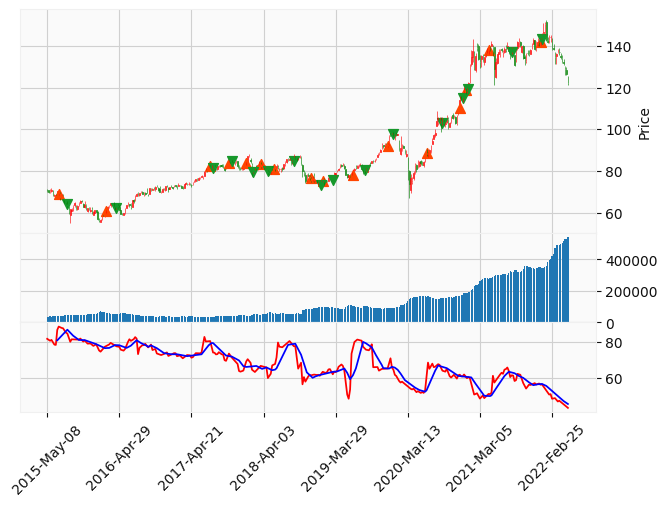

In [1]:
# 載入必要套件
from Data import getPriceAndShareHolder
from BackTest import ChartTrade, Performance
import pandas as pd
import mplfinance as mpf

# 取得回測資料
prod = "0050"
data = getPriceAndShareHolder(prod, "2007-01-01", "2022-05-18")

# 400張持有以上稱為大股東
data["major"] = data["12"] + data["13"] + data["14"] + data["15"]

# 算出指標過去的平均
data["major_ma"] = data.rolling(8)["major"].mean()
data["total_people_ma"] = data.rolling(8)["total_people"].mean()

# 初始部位
position = 0
trade = pd.DataFrame()
# 開始回測
for i in range(data.shape[0] - 1):
    # 取得策略會應用到的變數
    c_time = data.index[i]
    c_high = data.loc[c_time, "high"]
    c_close = data.loc[c_time, "close"]
    c_major = data.loc[c_time, "major"]
    c_major_ma = data.loc[c_time, "major_ma"]
    c_total_people = data.loc[c_time, "total_people"]
    c_total_people_ma = data.loc[c_time, "total_people_ma"]
    # 取下一期資料做為進場資料
    n_time = data.index[i + 1]
    n_open = data.loc[n_time, "open"]

    # 進場程序
    if position == 0:
        if c_major > c_major_ma and c_total_people > c_total_people_ma:
            position = 1
            order_i = i
            order_time = n_time
            order_price = n_open
            order_unit = 1
    # 出場程序
    elif position == 1:
        # 出場邏輯
        if c_major < c_major_ma:
            position = 0
            cover_time = n_time
            cover_price = n_open
            # 交易紀錄
            trade = trade._append(
                pd.Series(
                    [
                        prod,
                        "Buy",
                        order_time,
                        order_price,
                        cover_time,
                        cover_price,
                        order_unit,
                    ]
                ),
                ignore_index=True,
            )


# 繪製副圖
addp = []
addp.append(mpf.make_addplot(data["total_people"], panel=1, type="bar"))
addp.append(mpf.make_addplot(data["major"], panel=2, secondary_y=False, color="r"))
addp.append(mpf.make_addplot(data["major_ma"], panel=2, secondary_y=False, color="b"))

# 績效分析
Performance(trade, "ETF")
# 繪製K線圖與交易明細
ChartTrade(data, trade, addp=addp, v_enable=False)
